In [1]:
import xarray as xr
import numpy as np
import numpy as np
import xarray as xr
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import geopandas as gpd
import pycountry
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from shapely.geometry import box

In [2]:
diri = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power"
models = [
    "ACCESS-CM2", "CanESM5", "CMCC-CM2-SR5", "CMCC-ESM2",
    "HadGEM3-GC31-LL", "HadGEM3-GC31-MM", "MRI-ESM2-0"
]
periods = ["historical", "ssp585"]
filename="solar_drought_events"
short_per=["_BOC", "_EOC"]

In [40]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from itertools import groupby

def extract_events(series):
    """
    Return a list of (start_index, length) for each run of True in the 1D boolean array.
    """
    events = []
    in_event = False
    for idx, val in enumerate(series):
        if val and not in_event:
            in_event  = True
            start_idx = idx
            length    = 1
        elif val and in_event:
            length += 1
        elif not val and in_event:
            events.append((start_idx, length))
            in_event = False
    if in_event:
        events.append((start_idx, length))
    return events

models = [ "ACCESS-CM2", "CanESM5", "CMCC-CM2-SR5", "CMCC-ESM2","HadGEM3-GC31-LL", "HadGEM3-GC31-MM", "MRI-ESM2-0"]
periods = {
    "BOC": {"subpath": "historical", "years": list(range(1980, 2015))},
    "EOC": {"subpath": "ssp585",     "years": list(range(2065, 2100))}
}
diri = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power"

for model in models:
    for period, info in periods.items():
        base_dir  = os.path.join(diri, f"{model}_1x1grid", info["subpath"])
        clim_file = os.path.join(base_dir, "daily_mean_per_week.nc")
        weekly_clim = xr.open_dataset(clim_file)["specific generation"]
        threshold   = weekly_clim * 0.5

        # grab one sample year just to get lat/lon dims
        sample = xr.open_dataset(
            os.path.join(base_dir, f"daily_solar_power_{info['years'][0]}.nc")
        )["specific generation"]
        lats = sample["lat"].values   # shape (ny,)
        lons = sample["lon"].values   # shape (nx,)
        ny, nx = len(lats), len(lons)

        years = info["years"]
        nt_years = len(years)

        # preallocate an integer array [year,lat,lon]
        drought_days = np.zeros((nt_years, ny, nx), dtype=int)

        # loop over years, detect events & accumulate
        for iy, yr in enumerate(years):
            ds = xr.open_dataset(os.path.join(base_dir, f"daily_solar_power_{yr}.nc"))
            daily = ds["specific generation"]
            daily = daily.assign_coords(weekofyear=daily.time.dt.isocalendar().week)

            is_drought = daily < threshold.sel(weekofyear=daily.weekofyear)
            mask       = is_drought.values    # shape (time,ny,nx)
            times      = daily.time.values

            seasons = {
                "Winter": [12,1,2],
                "Spring": [3,4,5],
                "Summer": [6,7,8],
                "Autumn": [9,10,11]
            }

            # if you want annual totals, just collapse all seasons:
            full_mask = mask  # (time,ny,nx)

            # for each grid cell, extract drought runs and sum
            for iy2 in range(ny):
                for ix2 in range(nx):
                    runs = extract_events(full_mask[:,iy2,ix2])
                    total = sum(length for _,length in runs)
                    drought_days[iy, iy2, ix2] = total

        # build an xarray DataArray and Dataset
        da = xr.DataArray(
            drought_days,
            coords={
                "year": years,
                "lat":   lats,
                "lon":   lons
            },
            dims=["year","lat","lon"],
            name="drought_days"
        )
        ds_out = xr.Dataset({"drought_days": da})

        # write to netCDF
        out_nc = os.path.join(base_dir, f"solar_drought_days_per_year{period}.nc")
        ds_out.to_netcdf(out_nc)
        print(f"✅ Wrote yearly drought-days field → {out_nc}")


✅ Wrote yearly drought-days field → /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/ACCESS-CM2_1x1grid/historical/solar_drought_days_per_yearBOC.nc
✅ Wrote yearly drought-days field → /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/ACCESS-CM2_1x1grid/ssp585/solar_drought_days_per_yearEOC.nc
✅ Wrote yearly drought-days field → /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/CanESM5_1x1grid/historical/solar_drought_days_per_yearBOC.nc
✅ Wrote yearly drought-days field → /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/CanESM5_1x1grid/ssp585/solar_drought_days_per_yearEOC.nc
✅ Wrote yearly drought-days field → /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/CMCC-CM2-SR5_1x1grid/historical/solar_drought_days_per_yearBOC.nc
✅ Wrote yearly drought-days field → /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-bac

In [3]:
ds=xr.open_dataset("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/historical/solar_drought_days_per_yearBOC.nc")
ds

<xarray.Dataset> Size: 539kB
Dimensions:       (year: 35, lat: 40, lon: 48)
Coordinates:
  * year          (year) int64 280B 1980 1981 1982 1983 ... 2011 2012 2013 2014
  * lat           (lat) float64 320B 33.0 34.0 35.0 36.0 ... 69.0 70.0 71.0 72.0
  * lon           (lon) float64 384B -12.0 -11.0 -10.0 -9.0 ... 33.0 34.0 35.0
Data variables:
    drought_days  (year, lat, lon) int64 538kB ...

In [54]:
import os
import xarray as xr
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# ─── 0) Your region definitions ────────────────────────────────────
EU27 = [
    'AT','BE','BG','HR','CZ','DK','EE','FR','DE','GR',
    'HU','IE','IT','LV','LT','LU','MT','NL','PL','PT','RO',
    'SK','SI','ES','SE','CY'
]
extras = ['GB','NO','BA','ME','RS','AL','MK','CH','IS','TR','UA','BY','MD','XK']
region_codes = EU27 + extras

# ─── 1) Load & fix Natural Earth, keep only ISO_A2 in region_codes ──
ne50 = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).to_crs("EPSG:4326")

# correct ISO-A2 for a few special cases
world.loc[world.NAME_LONG=='France',             'ISO_A2'] = 'FR'
world.loc[world.NAME_LONG=='Russian Federation', 'ISO_A2'] = 'RU'
world.loc[world.NAME_LONG=='United Kingdom',     'ISO_A2'] = 'GB'
world.loc[world.NAME_LONG=='Norway',             'ISO_A2'] = 'NO'
world.loc[world.NAME_LONG.str.contains('Kosovo', na=False), 'ISO_A2'] = 'XK'

# filter to just your Europe + extras
eu = world[world.ISO_A2.isin(region_codes)][['ISO_A2','geometry']].copy()

# ─── 2) Settings for your drought-days files ───────────────────────
diri    = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power"
models  = [
    "ACCESS-CM2","CanESM5","CMCC-CM2-SR5",
    "CMCC-ESM2","HadGEM3-GC31-LL",
    "HadGEM3-GC31-MM","MRI-ESM2-0"
]
periods = {"BOC":"historical","EOC":"ssp585"}

records = []

# ─── 3) Loop over each model & period & year ──────────────────────
for model in models:
    for period, subpath in periods.items():
        nc_path = os.path.join(
        diri,
        f"{model}_1x1grid",
        subpath,
        f"solar_drought_days_per_year{period}.nc"
        )
        if not os.path.exists(nc_path):
            print("Missing:", nc_path)
            continue

        ds = xr.open_dataset(nc_path)
        da = ds["drought_days"]   # dims: year × lat × lon

        for yr in da.year.values:
            slice2d = da.sel(year=yr)
            df = slice2d.to_dataframe().reset_index().dropna(subset=['drought_days'])
            gdf = gpd.GeoDataFrame(
                df,
                geometry=[Point(xy) for xy in zip(df.lon, df.lat)],
                crs="EPSG:4326"
            )

            # spatial join, only keeping points inside your eu GeoDataFrame
            joined = gpd.sjoin(
                gdf, eu,
                how='inner',
                predicate='within'
            )

            # sum drought_days by ISO_A2
            agg = (
                joined
                .groupby('ISO_A2')['drought_days']
                .median()
                .reset_index(name='avg_drought_days')
            )
            agg['model']  = model
            agg['period'] = subpath
            agg['year']   = int(yr)

            records.append(agg)

# ─── 4) Combine & save ─────────────────────────────────────────────
if not records:
    raise RuntimeError("No data processed — check your paths!")

result = pd.concat(records, ignore_index=True)
# reorder columns
result = result[['model','period','ISO_A2','year','avg_drought_days']]

out_csv = os.path.join(diri, "country_drought_days_by_year.csv")
result.to_csv(out_csv, index=False)
print(f"✅ Saved to {out_csv}")


✅ Saved to /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/country_drought_days_by_year.csv


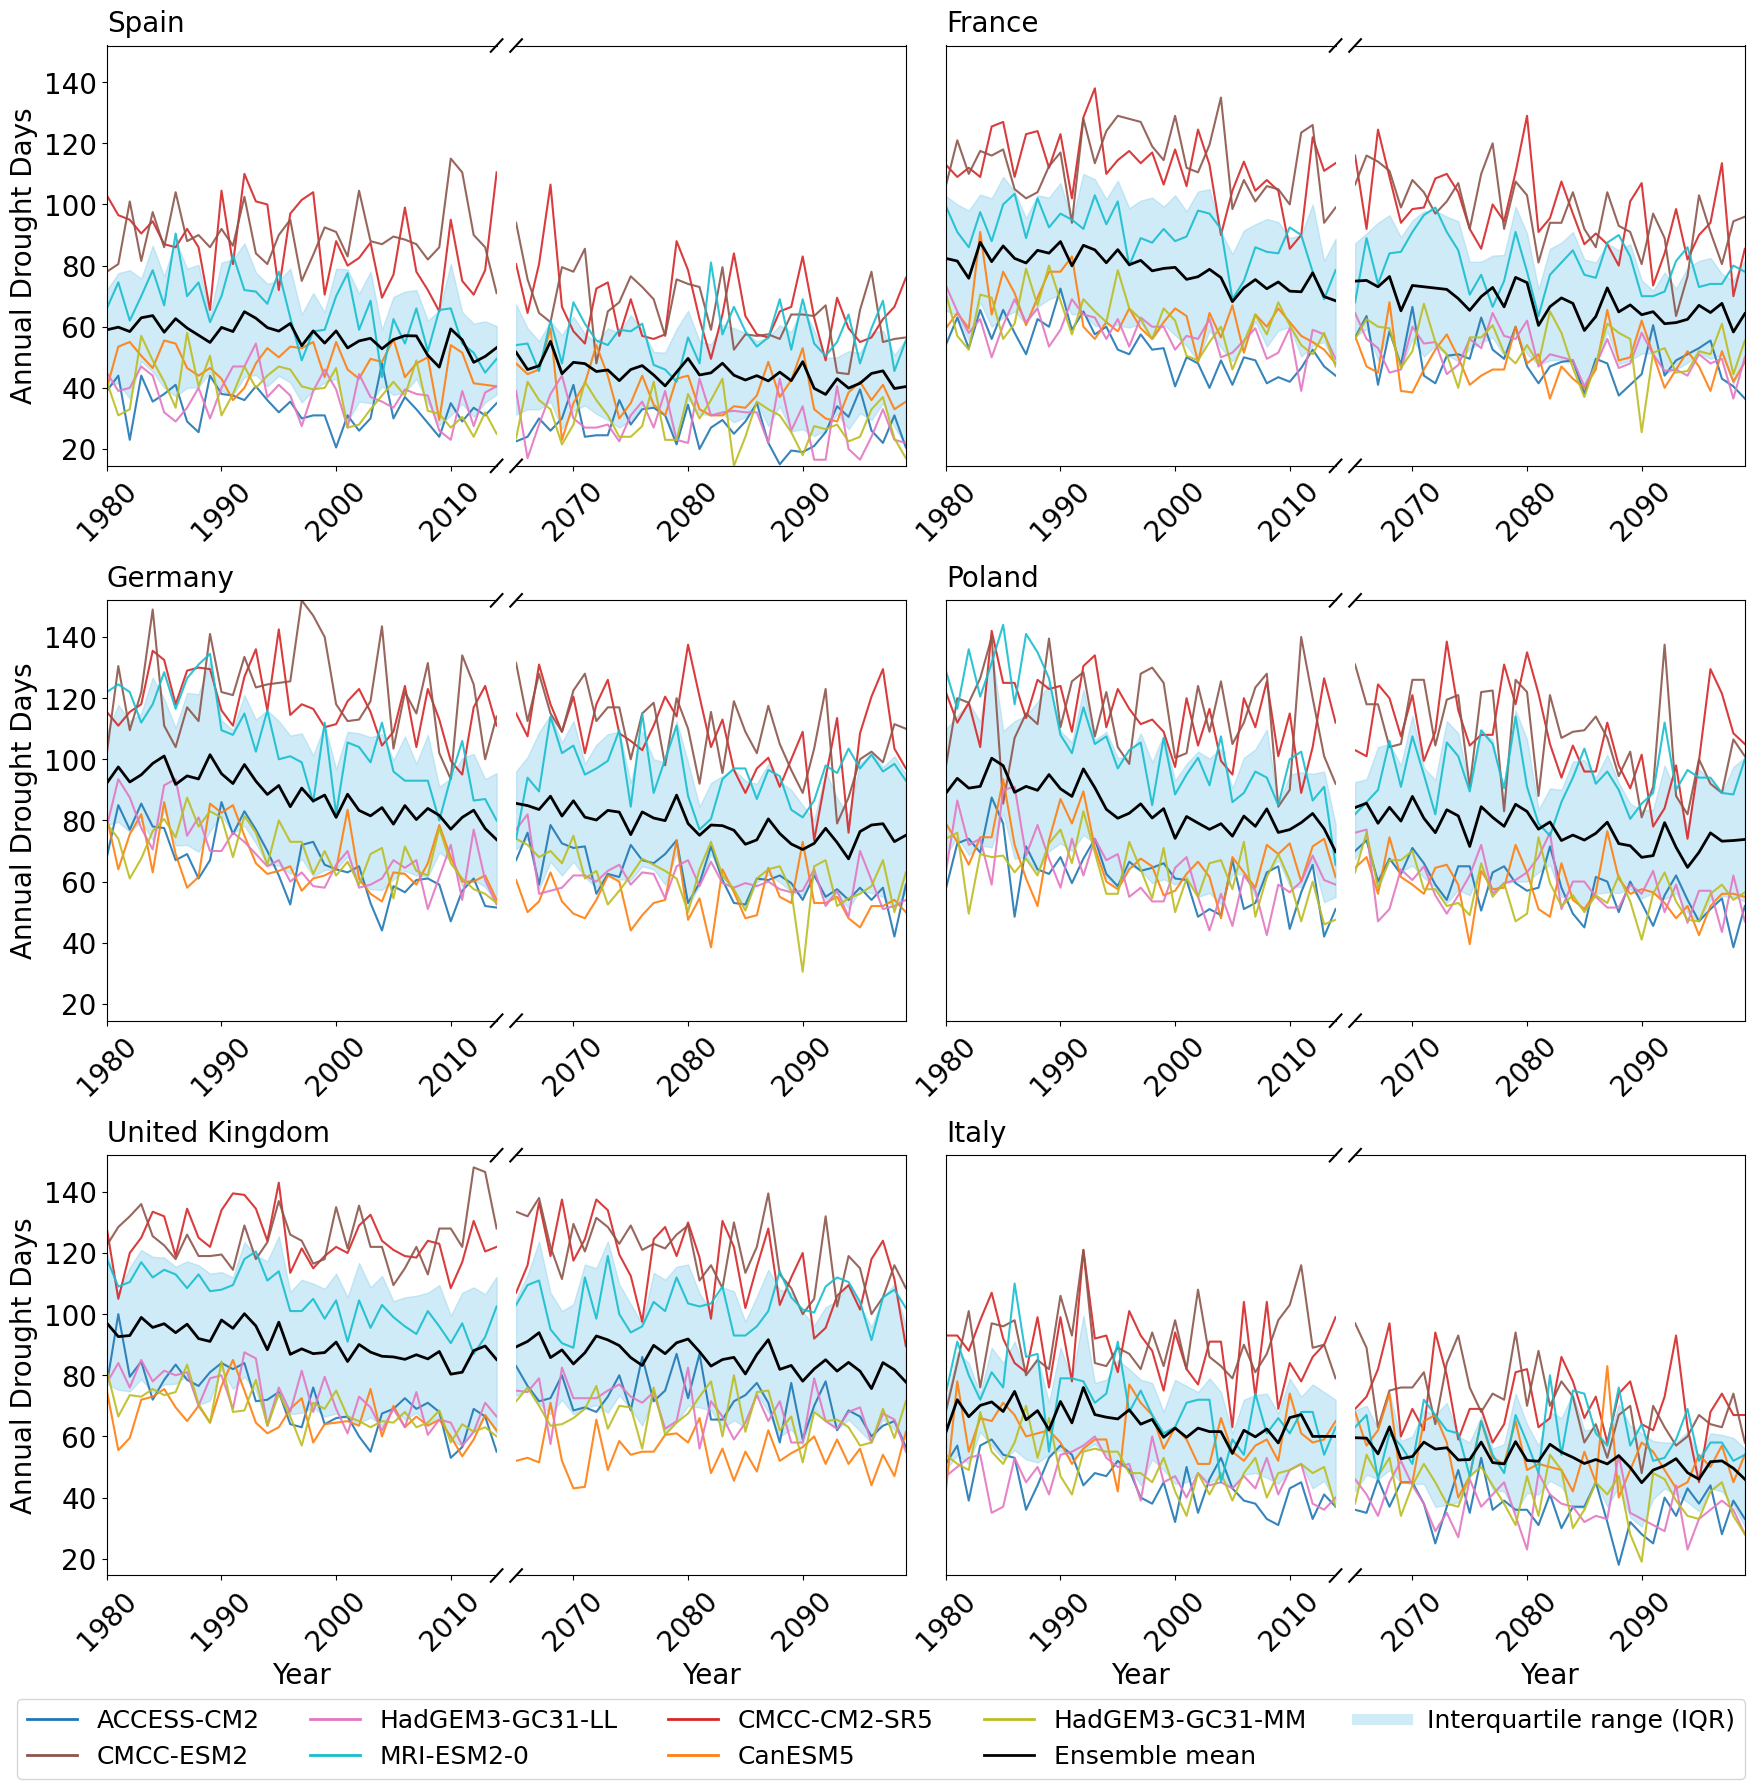

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

# --- 1) Data prep -----------------------------------------
selected_iso2 = ['ES','FR','DE','PL','GB','IT']
csv_path = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/country_drought_days_by_year.csv"
df = pd.read_csv(csv_path)
df6 = df[df['ISO_A2'].isin(selected_iso2)].copy()

iso2_to_name = {
    'ES': 'Spain', 'FR': 'France', 'DE': 'Germany',
    'PL': 'Poland','GB': 'United Kingdom','IT':'Italy'
}

model_colors = {
    "ACCESS-CM2":      "#1f77b4",
    "CMCC-ESM2":       "#8c564b",
    "HadGEM3-GC31-LL": "#e377c2",
    "MRI-ESM2-0":      "#17becf",
    "CMCC-CM2-SR5":    "#d62728",
    "CanESM5":         "#ff7f0e",
    "HadGEM3-GC31-MM": "#bcbd22",
}

ymin_all = df6['avg_drought_days'].min()
ymax_all = df6['avg_drought_days'].max()

# --- 2) Plotting (3×2 broken panels) ----------------------
fig = plt.figure(figsize=(18,18))
gs = gridspec.GridSpec(3,2, hspace=0.32, wspace=0.05)

for idx, iso2 in enumerate(selected_iso2):
    row, col = divmod(idx, 2)
    title = iso2_to_name[iso2]

    # left/right sub-axes
    subgs = gridspec.GridSpecFromSubplotSpec(
        1, 2, subplot_spec=gs[idx], width_ratios=[1,1], wspace=0.05
    )
    ax_h = fig.add_subplot(subgs[0])        # historical
    ax_f = fig.add_subplot(subgs[1])        # future (no sharey)

    # ——— completely strip y-axis on the right panel ———
    ax_f.spines['left'].set_visible(False)
    ax_f.set_yticks([])
    ax_f.set_yticklabels([])
    ax_f.set_ylabel("")                  
    ax_f.yaxis.label.set_visible(False)
    ax_f.tick_params(
        axis='y', which='both',
        left=False, right=False,
        labelleft=False, labelright=False
    )
    ax_f.yaxis.set_visible(False)

    # grab the two slices
    sub  = df6[df6['ISO_A2']==iso2]
    hist = sub[sub['year'] <= 2014]
    fut  = sub[sub['year'] >= 2065]

    # set identical y-limits by hand
    ax_h.set_ylim(ymin_all, ymax_all)
    ax_f.set_ylim(ymin_all, ymax_all)

    # set x-limits per slice
    ax_h.set_xlim(hist['year'].min(), hist['year'].max())
    ax_f.set_xlim(fut['year'].min(),   fut['year'].max())

    # hide the inner spines
    ax_h.spines['right'].set_visible(False)
    ax_f.spines['left'] .set_visible(False)

    # diagonal breaks
    d = .015
    for (ax, side) in [(ax_h,'right'), (ax_f,'left')]:
        kw = dict(transform=ax.transAxes, color='k', clip_on=False)
        if side=='right':
            ax.plot((1-d,1+d),(-d,+d), **kw)
            ax.plot((1-d,1+d),(1-d,1+d), **kw)
        else:
            ax.plot((-d,+d),(-d,+d), **kw)
            ax.plot((-d,+d),(1-d,1+d), **kw)

    # helper to plot each slice
    def plot_slice(df_slice, ax):
        pivot = (df_slice
                 .pivot(index='year', columns='model', values='avg_drought_days')
                 .sort_index())
        for m in pivot.columns:
            ax.plot(pivot.index, pivot[m],
                    color=model_colors[m], lw=1.5, alpha=0.9)
        em = pivot.mean(axis=1)
        q1 = pivot.quantile(0.25, axis=1)
        q3 = pivot.quantile(0.75, axis=1)
        ax.plot(em.index, em, color='k', lw=2)
        ax.fill_between(em.index, q1, q3, color='skyblue', alpha=0.4)

    plot_slice(hist, ax_h)
    plot_slice(fut,  ax_f)

    # …existing code above…

    # --- tick formatting ---
    # apply x‐axis style to both panels
    for ax in (ax_h, ax_f):
        ax.tick_params(axis='x', rotation=45, labelsize=20, pad=4)

    if col == 0:
        # left column: show y‐ticks & label on the historical subplot
        ax_h.tick_params(axis='y', labelsize=20, pad=4)
        ax_h.set_ylabel("Annual Drought Days", fontsize=20)
    else:
        # right column: completely hide y‐axis on both subplots
        for ax in (ax_h, ax_f):
            #ax.spines['left'].set_visible(False)
            ax.set_yticks([])
            ax.set_yticklabels([])
            ax.set_ylabel("")
            ax.tick_params(axis='y', left=False, labelleft=False)

    # bottom row only: x‐axis labels
    if row == 2:
        ax_h.set_xlabel("Year", fontsize=20)
        ax_f.set_xlabel("Year", fontsize=20)

    # title on left panel
    ax_h.set_title(title, fontsize=20, loc='left', pad=10)

# …existing code below…

# --- 3) Legend -----------------------------------------------
handles = [Line2D([],[],color=model_colors[m],lw=2) for m in model_colors]
labels  = list(model_colors.keys())
handles += [
    Line2D([],[],color='k',lw=2),
    Line2D([],[],color='skyblue',lw=8,alpha=0.4)
]
labels  += ["Ensemble mean","Interquartile range (IQR)"]

fig.legend(handles, labels,
           loc='lower center', ncol=5,
           frameon=True, bbox_to_anchor=(0.5, -0.02),
           fontsize=18)

plt.subplots_adjust(left=0.07, right=0.98, top=0.95, bottom=0.10)
plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/timeplot_drought_days.pdf", bbox_inches='tight', dpi=300)
plt.show()


In [14]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Find all BOC/EOC files
base_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power"
pattern  = os.path.join(base_dir, "*", "*", "solar_drought_events_*.csv")

file_paths = glob.glob(pattern)
if not file_paths:
    raise FileNotFoundError(f"No files found matching {pattern!r}")
print(file_paths)


['/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/CanESM5_1x1grid/ssp585/solar_drought_events_EOC.csv', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/CanESM5_1x1grid/historical/solar_drought_events_BOC.csv', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/ACCESS-CM2_1x1grid/ssp585/solar_drought_events_EOC.csv', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/ACCESS-CM2_1x1grid/historical/solar_drought_events_BOC.csv', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/CMCC-CM2-SR5_1x1grid/ssp585/solar_drought_events_EOC.csv', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/CMCC-CM2-SR5_1x1grid/historical/solar_drought_events_BOC.csv', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/HadGEM3-GC31-MM_1x1grid/ssp585/solar_drought_events_EOC.csv', '/work/user

In [18]:
# 2) Read & concatenate, extracting model and period
records = []
for fp in file_paths:
    df = pd.read_csv(fp)
    
    # split into components
    parts = os.path.normpath(fp).split(os.sep)
    # find the index of "power"
    i = parts.index("power")
    # the model folder is exactly one step after "power"
    model_dir = parts[i+1]            # e.g. "ACCESS-CM2_1x1grid"
    model     = model_dir.split("_")[0]  # -> "ACCESS-CM2"

    
    # filename ends with "_BOC.csv" or "_EOC.csv"
    period = os.path.splitext(os.path.basename(fp))[0].split("_")[-1]
    
    df["model"]  = model
    df["period"] = period
    records.append(df)

all_events = pd.concat(records, ignore_index=True)
print(all_events)


                    model period  year  season   lat   lon  start_month  \
0                 CanESM5    EOC  2065  Winter  35.0 -11.0            1   
1                 CanESM5    EOC  2065  Winter  35.0 -11.0            1   
2                 CanESM5    EOC  2065  Winter  35.0 -11.0            1   
3                 CanESM5    EOC  2065  Winter  35.0 -11.0            1   
4                 CanESM5    EOC  2065  Winter  35.0 -11.0            1   
...                   ...    ...   ...     ...   ...   ...          ...   
29483224  HadGEM3-GC31-LL    BOC  2014  Autumn  64.0  25.0           11   
29483225  HadGEM3-GC31-LL    BOC  2014  Autumn  64.0  25.0           11   
29483226  HadGEM3-GC31-LL    BOC  2014  Autumn  64.0  25.0           11   
29483227  HadGEM3-GC31-LL    BOC  2014  Autumn  64.0  25.0           11   
29483228  HadGEM3-GC31-LL    BOC  2014  Autumn  64.0  25.0           11   

          duration dur_bin  
0                1     0-1  
1                1     0-1  
2           

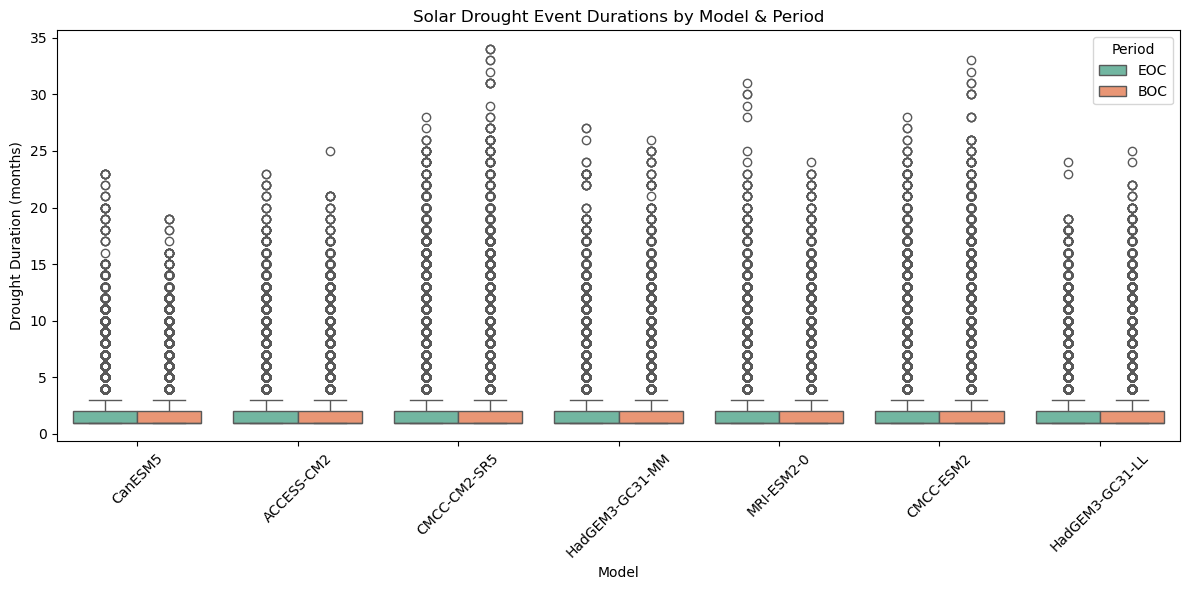

In [19]:
# 3) Tidy for plotting: keep only model, period, duration
#    (adjust 'duration' if your column is named differently)
tidy = all_events[["model", "period", "duration"]].dropna()

# 4) Plot: one box per model × period
plt.figure(figsize=(12,6))
sns.boxplot(
    data=tidy, 
    x="model", 
    y="duration",
    hue="period",
    palette="Set2"
)
plt.xticks(rotation=45)
plt.xlabel("Model")
plt.ylabel("Drought Duration (days)")
plt.title("Solar Drought Event Durations by Model & Period")
plt.legend(title="Period")
plt.tight_layout()
plt.show()


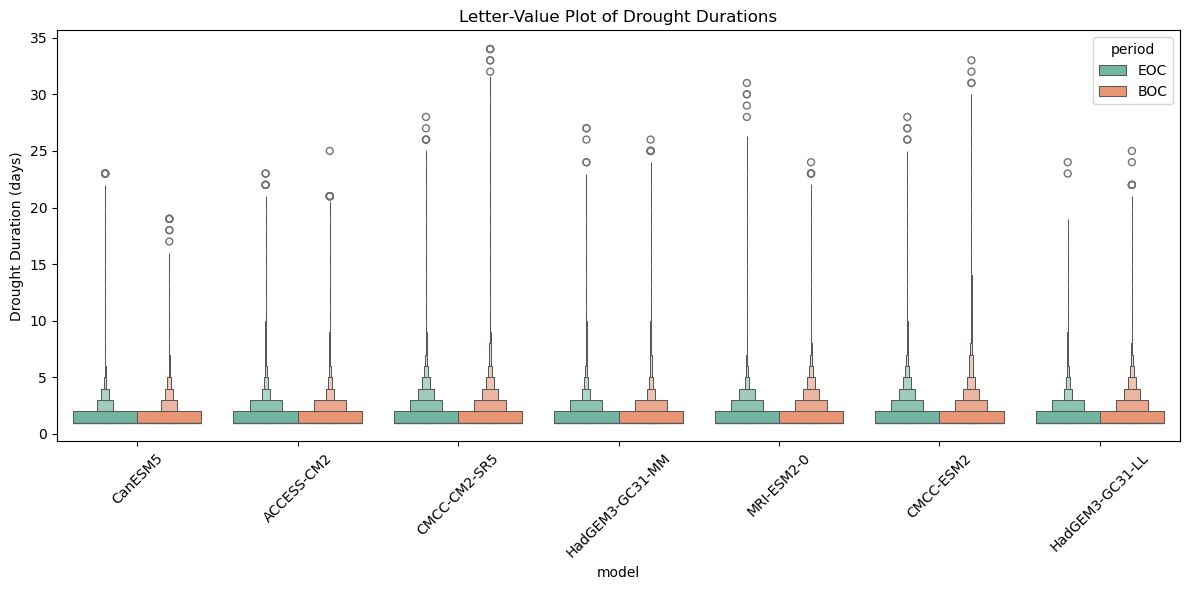

In [22]:
plt.figure(figsize=(12,6))
sns.boxenplot(
  data=tidy,
  x="model",
  y="duration",
  hue="period",
  palette="Set2"
)
plt.xticks(rotation=45)
plt.ylabel("Drought Duration (days)")
plt.title("Letter‐Value Plot of Drought Durations")
plt.tight_layout()
plt.show()

/tmp/ipykernel_32208/4130841782.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


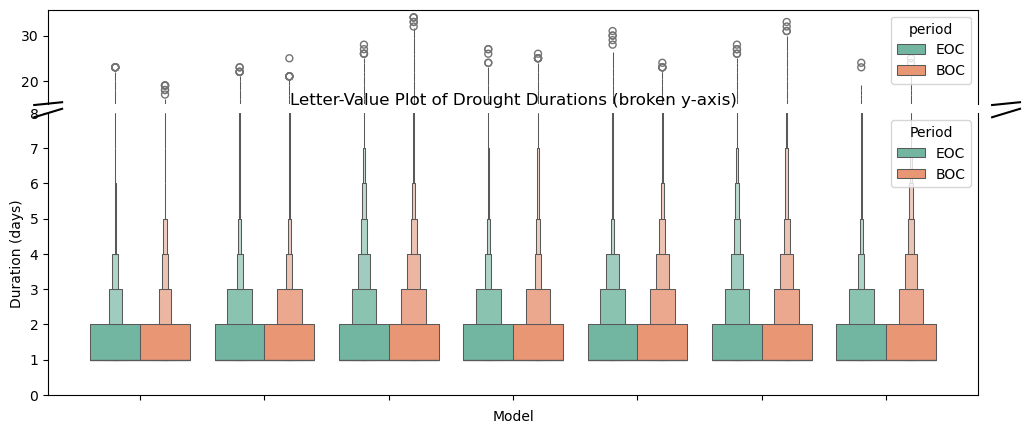

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# Create a 2-row grid: top small (tail), bottom large (bulk)
fig = plt.figure(figsize=(12, 5))
gs  = gridspec.GridSpec(2, 1, height_ratios=[1, 3], hspace=0.05)

ax_top    = fig.add_subplot(gs[0])
ax_bottom = fig.add_subplot(gs[1], sharex=ax_top)

# Common arguments for both axes
boxen_kwargs = dict(
    data=tidy,
    x="model",
    y="duration",
    hue="period",
    palette="Set2",
    dodge=True
)

# Draw boxen on both
sns.boxenplot(ax=ax_top,    **boxen_kwargs)
sns.boxenplot(ax=ax_bottom, **boxen_kwargs)

# Set y-limits for the “zoom windows”
ax_bottom.set_ylim(0, 8)
ax_top   .set_ylim(15, tidy["duration"].max()*1.05)

# Hide the inner spines & ticks
ax_top.spines["bottom"].set_visible(False)
ax_bottom.spines["top"].set_visible(False)
ax_top   .tick_params(bottom=False)
ax_bottom.tick_params(top=False)

# Diagonal “break” marks
d = .015
# top axes: draw break at bottom
for x in (-d, 1+d):
    ax_top.plot([x, x+.03], [-d, +d], transform=ax_top.transAxes, color="k", clip_on=False)
# bottom axes: draw break at top
for x in (-d, 1+d):
    ax_bottom.plot([x, x+.03], [1-d, 1+d], transform=ax_bottom.transAxes, color="k", clip_on=False)

# Clean up labels
ax_bottom.set_xlabel("Model")
ax_top   .set_xlabel("")  
ax_top   .set_xticklabels([])  

ax_bottom.set_ylabel("Duration (days)")
ax_top   .set_ylabel("")

# Title and legend
ax_bottom.set_title("Letter-Value Plot of Drought Durations (broken y-axis)")
handles, labels = ax_bottom.get_legend_handles_labels()
ax_bottom.legend(handles, labels, title="Period", loc="upper right")

plt.tight_layout()
plt.show()


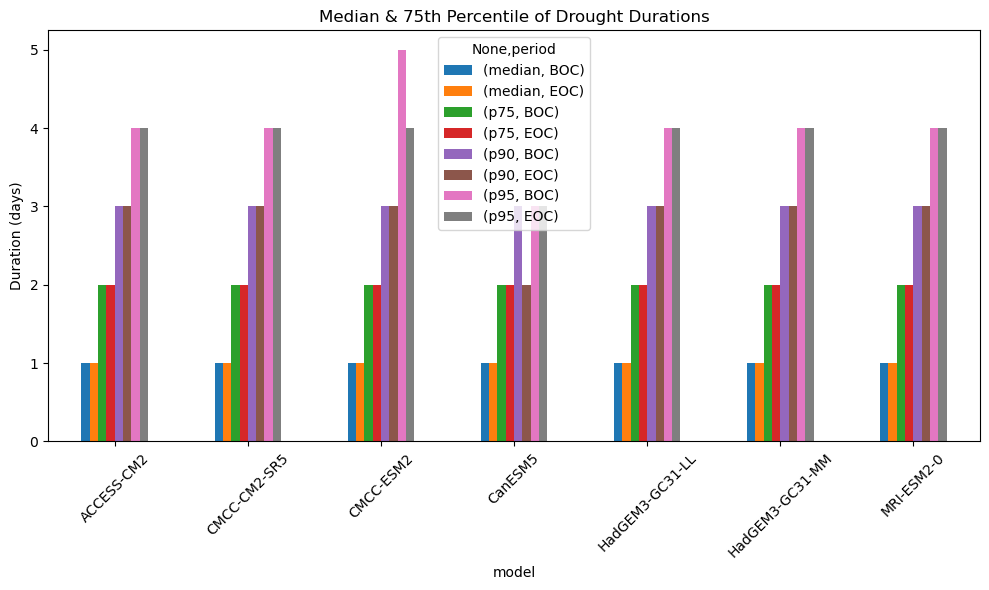

In [28]:
summary = tidy.groupby(["model","period"])["duration"] \
              .agg(median="median", p75=lambda x: x.quantile(0.75), p90=lambda x: x.quantile(0.9), p95=lambda x: x.quantile(0.95)) \
              .unstack()
summary.plot.bar(figsize=(10,6))
plt.ylabel("Duration (days)")
plt.title("Median & 75th Percentile of Drought Durations")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

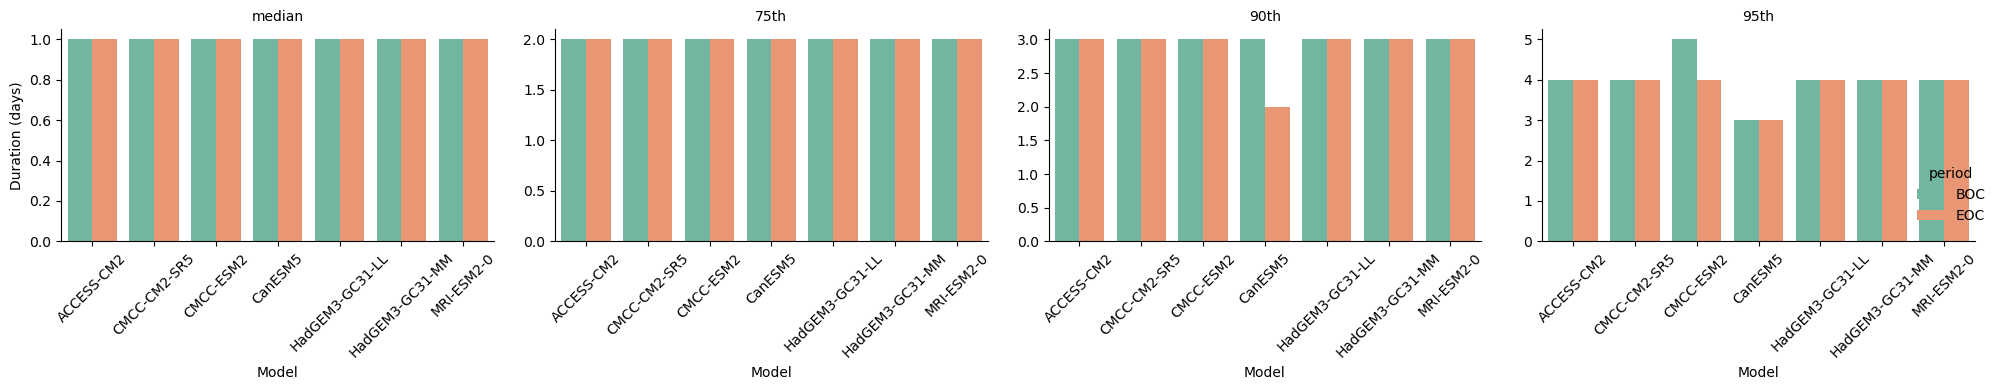

In [33]:
# …existing code above…

# 1) compute quantiles in long form
stats = (
    tidy
    .groupby(["model","period"])["duration"]
    .quantile([0.5, 0.75, 0.9, 0.95])
    .rename_axis(index=["model","period","quantile"])
    .reset_index(name="value")
)
# map the quantile floats to nicer names
stats["quantile"] = stats["quantile"].map({
    0.5:  "median",
    0.75: "75th",
    0.9:  "90th",
    0.95: "95th"
})

# 2) facet‐grid barplot
g = sns.catplot(
    data=stats,
    x="model",
    y="value",
    hue="period",
    col="quantile",
    kind="bar",
    palette="Set2",
    sharey=False,
    height=4, aspect=1.2
)
g.set_axis_labels("Model", "Duration (days)")
g.set_titles("{col_name}")
for ax in g.axes.flatten():
    ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

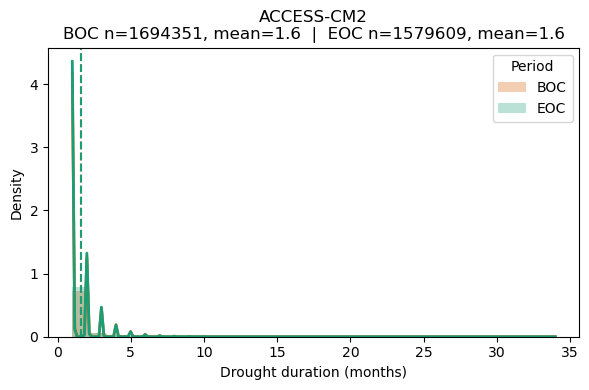

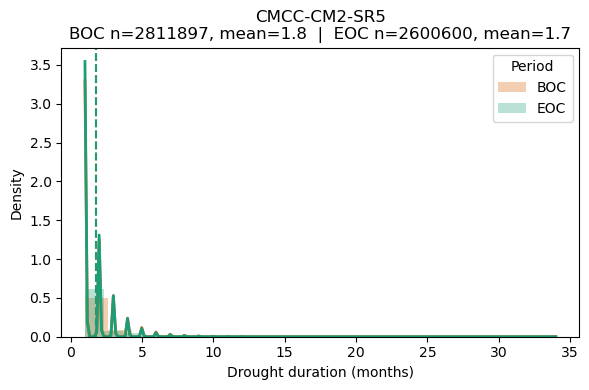

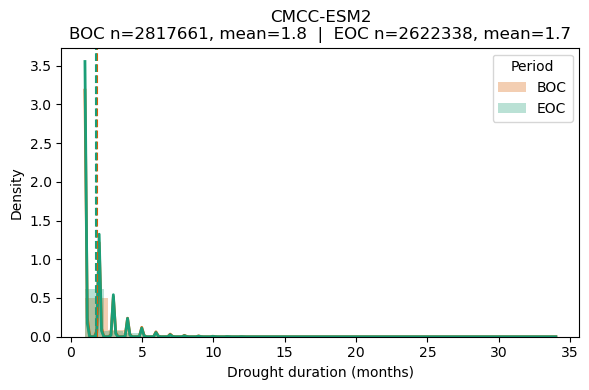

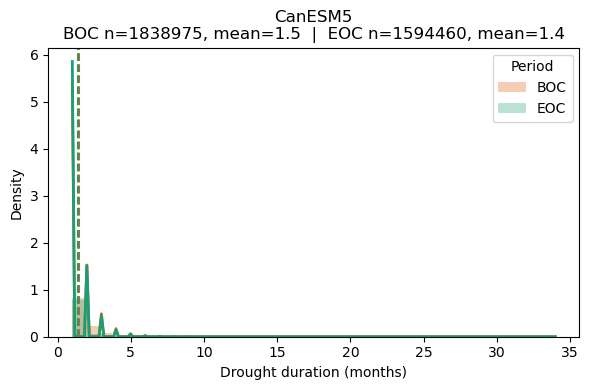

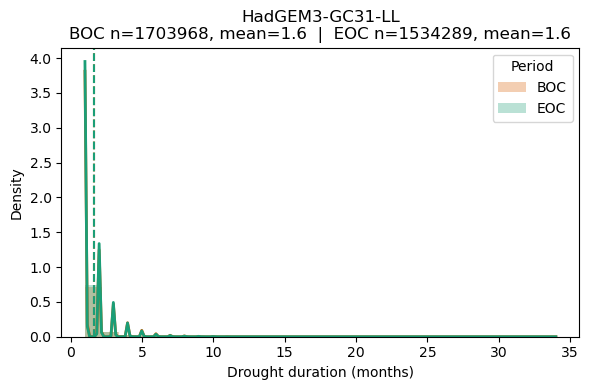

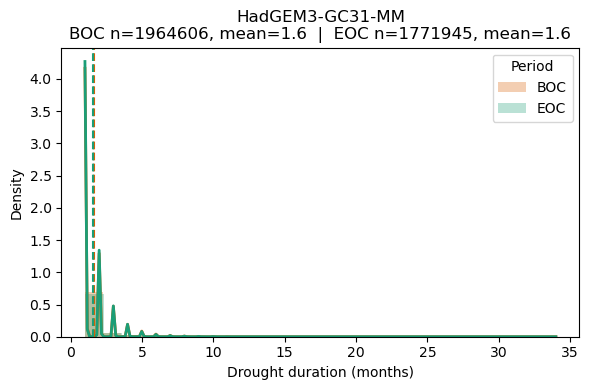

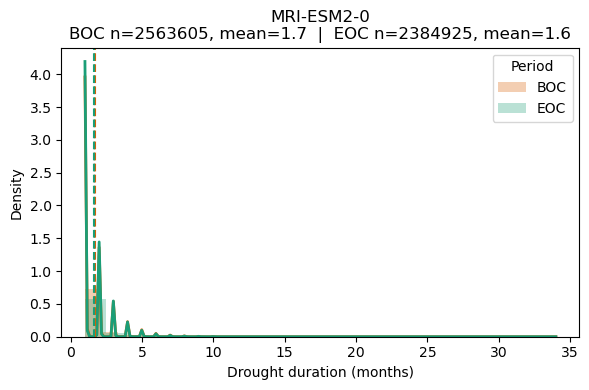

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# --- assume `all_events` is your combined DataFrame with columns:
#     model, period (BOC/EOC), and duration (or solar generation)
# If it's not loaded yet, load it first exactly as before.
#
# here we’ll pivot to get arrays of values for each model & period

models = sorted(all_events['model'].unique())
periods = ['BOC','EOC']
colors  = {'BOC':'#d95f02','EOC':'#1b9e77'}

# pre‐compute global x‐range for KDE smoothing
xmin = all_events['duration'].min()
xmax = all_events['duration'].max()
xs   = np.linspace(xmin, xmax, 200)

for model in models:
    # filter per‐model
    dfm = all_events[all_events['model']==model]
    boc_vals = dfm.loc[dfm['period']=='BOC','duration'].values
    eoc_vals = dfm.loc[dfm['period']=='EOC','duration'].values

    # skip if either is empty
    if len(boc_vals)==0 or len(eoc_vals)==0:
        continue

    # build the KDE objects
    kde_boc = gaussian_kde(boc_vals)
    kde_eoc = gaussian_kde(eoc_vals)

    plt.figure(figsize=(6,4))
    # histograms
    plt.hist(boc_vals, bins=20, density=True,
             color=colors['BOC'], alpha=0.3, label='BOC')
    plt.hist(eoc_vals, bins=20, density=True,
             color=colors['EOC'], alpha=0.3, label='EOC')

    # KDE curves
    plt.plot(xs, kde_boc(xs), color=colors['BOC'], lw=2)
    plt.plot(xs, kde_eoc(xs), color=colors['EOC'], lw=2)

    # mean lines
    plt.axvline(boc_vals.mean(), color=colors['BOC'],
                linestyle='--', lw=1.5)
    plt.axvline(eoc_vals.mean(), color=colors['EOC'],
                linestyle='--', lw=1.5)

    # titles & labels
    plt.title(f'{model}\n'
              f'BOC n={len(boc_vals)}, mean={boc_vals.mean():.1f}  |  '
              f'EOC n={len(eoc_vals)}, mean={eoc_vals.mean():.1f}')
    plt.xlabel('Drought duration (months)')
    plt.ylabel('Density')

    plt.legend(title='Period')
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_32208/2383429145.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.95])


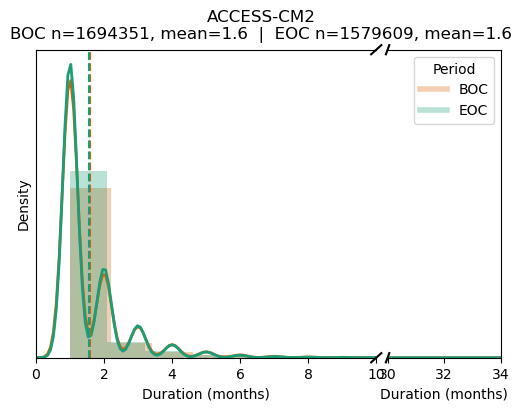

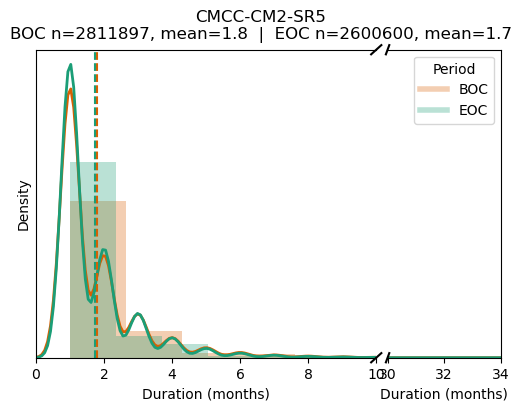

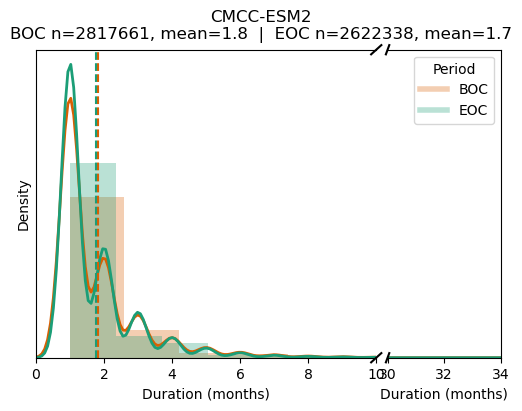

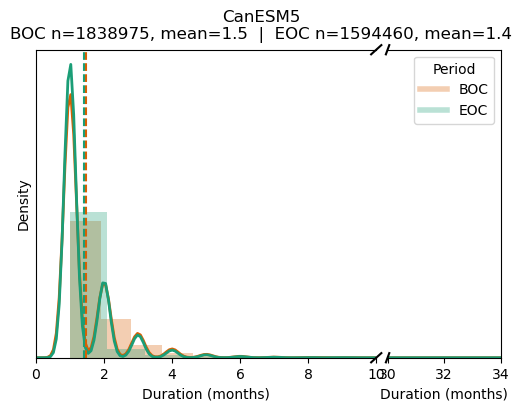

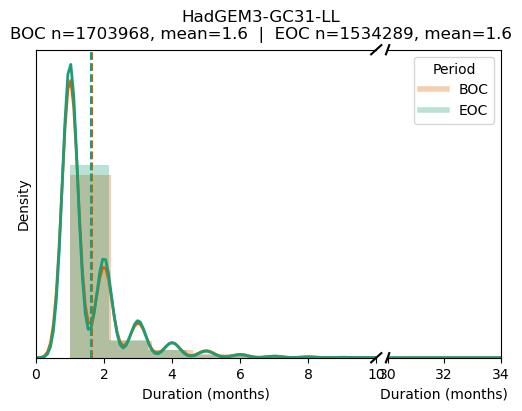

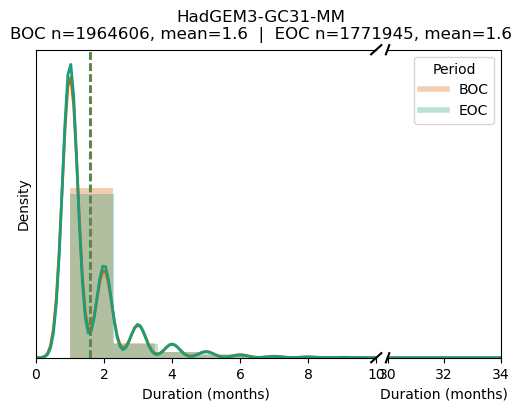

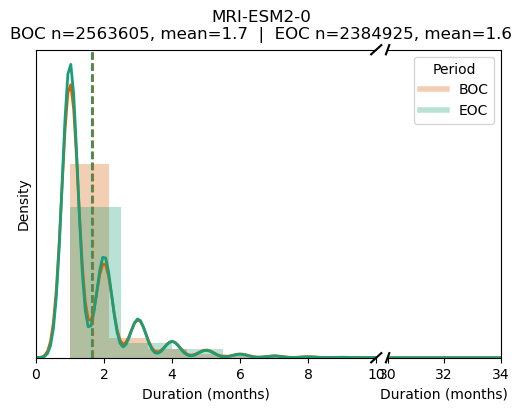

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.gridspec as gridspec

models  = sorted(all_events['model'].unique())
colors  = {'BOC':'#d95f02','EOC':'#1b9e77'}

# global limits
xmin, xmax = 0, all_events['duration'].max()
xs         = np.linspace(xmin, xmax, 400)

for model in models:
    dfm      = all_events[all_events['model']==model]
    boc_vals = dfm.loc[dfm.period=='BOC','duration'].values
    eoc_vals = dfm.loc[dfm.period=='EOC','duration'].values
    if boc_vals.size==0 or eoc_vals.size==0:
        continue

    kde_boc = gaussian_kde(boc_vals, bw_method=0.2)
    kde_eoc = gaussian_kde(eoc_vals, bw_method=0.2)

    # set up broken‐x figure
    fig = plt.figure(figsize=(6,4))
    gs  = gridspec.GridSpec(1,2, width_ratios=[3,1], wspace=0.05)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharey=ax1)

    # plot both halves
    for ax in (ax1, ax2):
        ax.hist(boc_vals, bins=20, density=True,
                color=colors['BOC'], alpha=0.3)
        ax.hist(eoc_vals, bins=20, density=True,
                color=colors['EOC'], alpha=0.3)
        ax.plot(xs, kde_boc(xs), color=colors['BOC'], lw=2)
        ax.plot(xs, kde_eoc(xs), color=colors['EOC'], lw=2)
        ax.axvline(boc_vals.mean(), color=colors['BOC'], linestyle='--', lw=1.5)
        ax.axvline(eoc_vals.mean(), color=colors['EOC'], linestyle='--', lw=1.5)

    # zoom ranges
    ax1.set_xlim(0, 10)
    ax2.set_xlim(30, xmax)

    # remove inner spines
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax1.tick_params(right=False)
    ax2.tick_params(left=False)

    # draw diagonal “break” marks
    d = .015
    kwargs1 = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((1-d,1+d),(-d,+d), **kwargs1)
    ax1.plot((1-d,1+d),(1-d,1+d), **kwargs1)
    kwargs2 = dict(transform=ax2.transAxes, color='k', clip_on=False)
    ax2.plot((-d,+d),(1-d,1+d), **kwargs2)
    ax2.plot((-d,+d),(-d,+d), **kwargs2)

    # labels & title
    ax2.set_yticks([])  # only left shows y-axis
    ax1.set_ylabel("Density")
    ax2.set_ylabel("")
    ax1.set_xlabel("Duration (months)")
    ax2.set_xlabel("Duration (months)")
    fig.suptitle(f"{model}\nBOC n={boc_vals.size}, mean={boc_vals.mean():.1f}  |  "
                 f"EOC n={eoc_vals.size}, mean={eoc_vals.mean():.1f}", y=0.98)
    ax2.legend(
        handles=[
            plt.Line2D([],[],color=colors['BOC'],lw=4,alpha=0.3),
            plt.Line2D([],[],color=colors['EOC'],lw=4,alpha=0.3)
        ],
        labels=['BOC','EOC'],
        title="Period",
        loc='upper right'
    )
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()


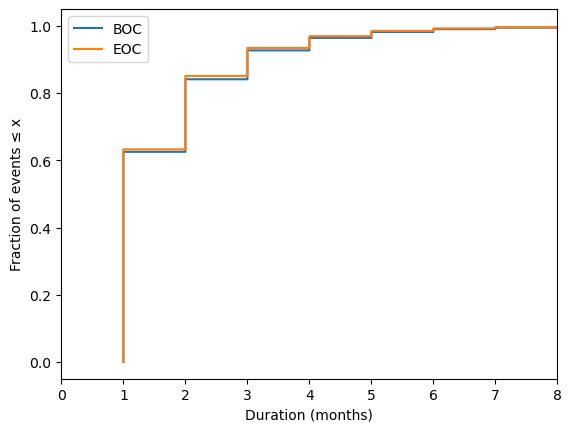

In [36]:
for period, vals in [('BOC', boc_vals), ('EOC', eoc_vals)]:
    x = np.sort(vals)
    y = np.arange(len(x)) / len(x)
    plt.step(x, y, where='post', label=period)
plt.xlim(0,8)
plt.xlabel("Duration (months)")
plt.ylabel("Fraction of events ≤ x")
plt.legend()


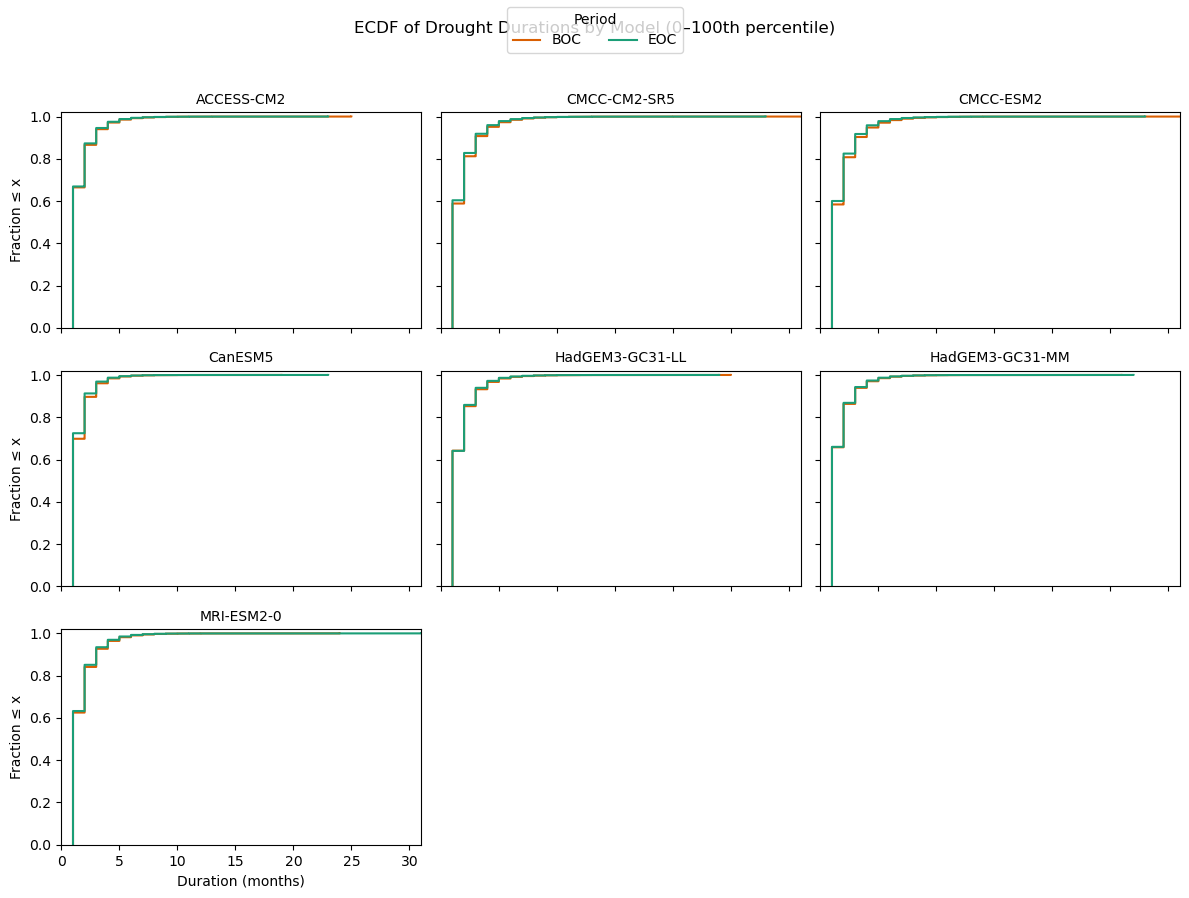

In [38]:
import numpy as np
import matplotlib.pyplot as plt

models = sorted(all_events['model'].unique())
colors  = {'BOC':'#d95f02','EOC':'#1b9e77'}

n      = len(models)
cols   = 3
rows   = int(np.ceil(n/cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3),
                         sharex=True, sharey=True)
axes = axes.flatten()

for idx, model in enumerate(models):
    ax = axes[idx]
    dfm      = all_events[all_events['model']==model]
    boc_vals = np.sort(dfm.loc[dfm['period']=='BOC','duration'].values)
    eoc_vals = np.sort(dfm.loc[dfm['period']=='EOC','duration'].values)

    # compute cumulative fractions
    boc_cum = np.arange(1, len(boc_vals)+1) / len(boc_vals)
    eoc_cum = np.arange(1, len(eoc_vals)+1) / len(eoc_vals)

    # plot ECDFs
    ax.step(boc_vals, boc_cum, where='post', color=colors['BOC'], label='BOC')
    ax.step(eoc_vals, eoc_cum, where='post', color=colors['EOC'], label='EOC')

    # axes limits
    ax.set_xlim(0, max(boc_vals.max(), eoc_vals.max()))
    ax.set_ylim(0, 1.02)

    # title
    ax.set_title(model, fontsize=10)

    # determine row & col from idx
    row = idx // cols
    col = idx % cols

    # only bottom row: set xlabel
    if row == rows - 1:
        ax.set_xlabel("Duration (months)")

    # only first column: set ylabel
    if col == 0:
        ax.set_ylabel("Fraction ≤ x")

# hide any unused subplots
for ax in axes[n:]:
    ax.set_visible(False)

# shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Period", loc='upper center', ncol=2)

plt.suptitle("ECDF of Drought Durations by Model (0–100th percentile)", y=0.98)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()



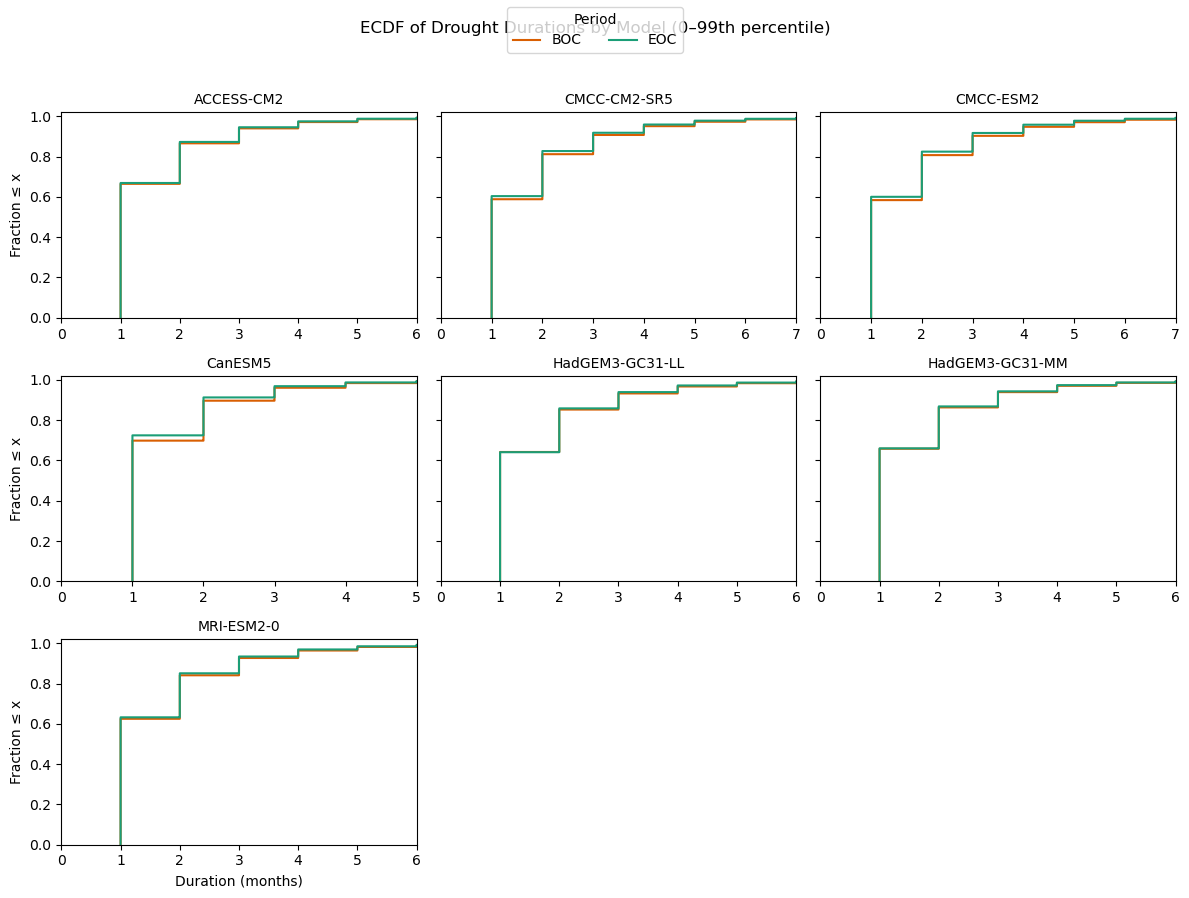

In [39]:
import numpy as np
import matplotlib.pyplot as plt

models = sorted(all_events['model'].unique())
colors = {'BOC':'#d95f02','EOC':'#1b9e77'}

n    = len(models)
cols = 3
rows = int(np.ceil(n/cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3), sharey=True)
axes = axes.flatten()

for idx, model in enumerate(models):
    ax = axes[idx]
    dfm      = all_events[all_events['model']==model]
    boc_vals = np.sort(dfm.loc[dfm.period=='BOC','duration'].values)
    eoc_vals = np.sort(dfm.loc[dfm.period=='EOC','duration'].values)

    # ECDF
    boc_cum = np.arange(1, len(boc_vals)+1)/len(boc_vals)
    eoc_cum = np.arange(1, len(eoc_vals)+1)/len(eoc_vals)

    ax.step(boc_vals, boc_cum, where='post', color=colors['BOC'], label='BOC')
    ax.step(eoc_vals, eoc_cum, where='post', color=colors['EOC'], label='EOC')

    # compute p99
    p99 = np.percentile(np.concatenate([boc_vals, eoc_vals]), 99)

    # zoom to [0, p99]
    ax.set_xlim(0, p99)
    ax.set_ylim(0, 1.02)

    ax.set_title(model, fontsize=10)

    # row/col for labeling
    row = idx // cols
    col = idx % cols
    if row == rows - 1:
        ax.set_xlabel("Duration (months)")
    if col == 0:
        ax.set_ylabel("Fraction ≤ x")

# hide unused
for ax in axes[n:]:
    ax.set_visible(False)

# single legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Period", loc='upper center', ncol=2)

plt.suptitle("ECDF of Drought Durations by Model (0–99th percentile)", y=0.98)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


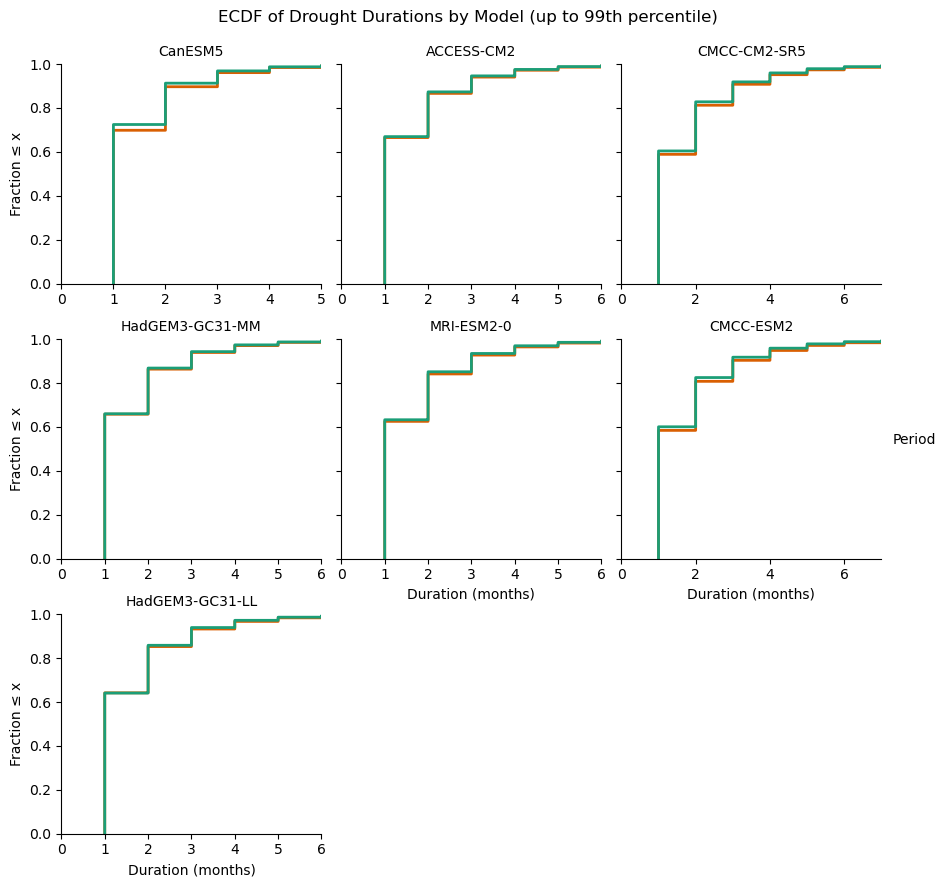

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# tidy DataFrame: columns model, period, duration
# all_events is assumed already loaded

g = sns.FacetGrid(
    all_events,
    col="model",
    col_wrap=3,
    height=3,
    sharex=False,
    sharey=True
)
g.map_dataframe(
    sns.ecdfplot,
    x="duration",
    hue="period",
    palette={"BOC":"#d95f02","EOC":"#1b9e77"},
    linewidth=2
)

# tweak aesthetics
g.add_legend(title="Period")
g.set_axis_labels("Duration (months)", "Fraction ≤ x")
g.set_titles("{col_name}")
for ax in g.axes.flatten():
    # zoom to 99th percentile per model
    model = ax.get_title()
    vals = all_events.loc[all_events.model==model, "duration"]
    p99  = np.percentile(vals, 99)
    ax.set_xlim(0, p99)
    ax.set_ylim(0,1)

plt.subplots_adjust(top=0.92)
g.fig.suptitle("ECDF of Drought Durations by Model (up to 99th percentile)")
plt.show()


/tmp/ipykernel_32208/1921021206.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


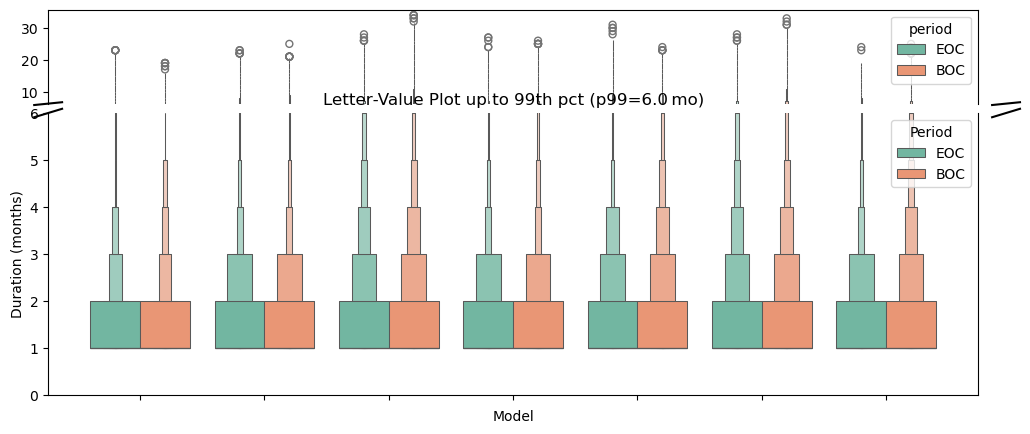

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# Compute the 99th percentile of duration
p99 = tidy["duration"].quantile(0.99)
pmax = tidy["duration"].max()

# Create a 2-row grid: top small (tail), bottom large (bulk)
fig = plt.figure(figsize=(12, 5))
gs  = gridspec.GridSpec(2, 1, height_ratios=[1, 3], hspace=0.05)

ax_top    = fig.add_subplot(gs[0])
ax_bottom = fig.add_subplot(gs[1], sharex=ax_top)

# Common arguments
boxen_kwargs = dict(
    data=tidy,
    x="model",
    y="duration",
    hue="period",
    palette="Set2",
    dodge=True
)

# Draw boxen on both
sns.boxenplot(ax=ax_top,    **boxen_kwargs)
sns.boxenplot(ax=ax_bottom, **boxen_kwargs)

# Set y‐limits to [p99, max] on top and [0, p99] on bottom
ax_bottom.set_ylim(0, p99)
ax_top   .set_ylim(p99 + 0.01*(pmax-p99), pmax*1.05)

# Hide the inner spines & ticks
ax_top.spines["bottom"].set_visible(False)
ax_bottom.spines["top"].set_visible(False)
ax_top   .tick_params(bottom=False)
ax_bottom.tick_params(top=False)

# Diagonal “break” marks
d = .015
# at bottom of top axes
for x in (-d, 1+d):
    ax_top.plot([x, x+.03], [-d, +d], transform=ax_top.transAxes,
                color="k", clip_on=False)
# at top of bottom axes
for x in (-d, 1+d):
    ax_bottom.plot([x, x+.03], [1-d, 1+d], transform=ax_bottom.transAxes,
                   color="k", clip_on=False)

# Labels
ax_bottom.set_xlabel("Model")
ax_top   .set_xlabel("")  
ax_top   .set_xticklabels([])  

ax_bottom.set_ylabel("Duration (months)")
ax_top   .set_ylabel("")

# Title & legend
ax_bottom.set_title(f"Letter‐Value Plot up to 99th pct (p99={p99:.1f} mo)")
handles, labels = ax_bottom.get_legend_handles_labels()
ax_bottom.legend(handles, labels, title="Period", loc="upper right")

plt.tight_layout()
plt.show()


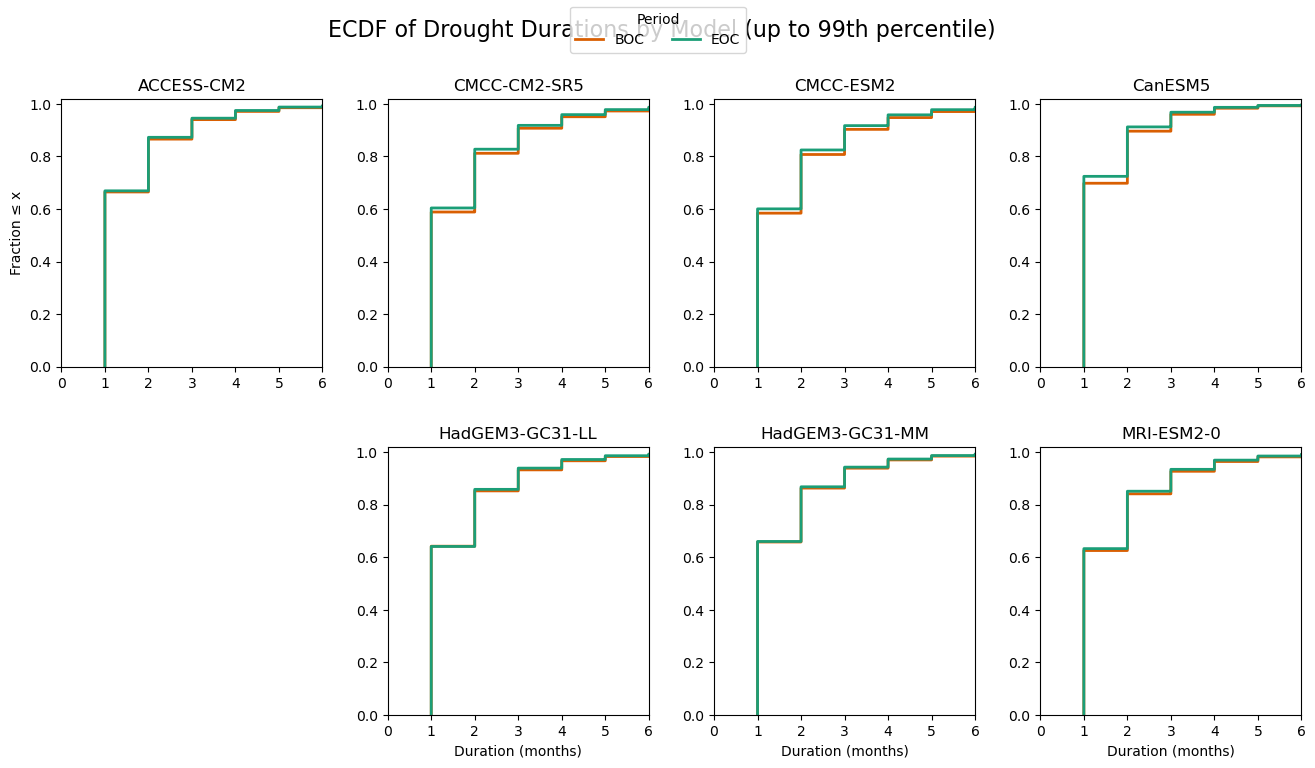

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

models = sorted(all_events['model'].unique())
colors = {'BOC':'#d95f02','EOC':'#1b9e77'}

# Compute the global 99th percentile across all data
p99_global = all_events['duration'].quantile(0.99)

# Set up a 2×4 GridSpec, with bottom row leftmost cell empty
fig = plt.figure(figsize=(16, 8))
gs  = GridSpec(2, 4, figure=fig, height_ratios=[1,1], hspace=0.3, wspace=0.25)

axes = []
# Top row: 4 models
for i in range(4):
    ax = fig.add_subplot(gs[0, i])
    axes.append(ax)

# Bottom row: 3 models, centered in columns 1,2,3
for j in range(3):
    ax = fig.add_subplot(gs[1, j+1])  
    axes.append(ax)

# Plot each model
for ax, model in zip(axes, models):
    dfm      = all_events[all_events['model']==model]
    boc_vals = np.sort(dfm.loc[dfm.period=='BOC','duration'])
    eoc_vals = np.sort(dfm.loc[dfm.period=='EOC','duration'])

    sns.ecdfplot(boc_vals, ax=ax, label='BOC', color=colors['BOC'], linewidth=2)
    sns.ecdfplot(eoc_vals, ax=ax, label='EOC', color=colors['EOC'], linewidth=2)

    ax.set_title(model, fontsize=12)
    ax.set_xlim(0, p99_global)
    ax.set_ylim(0, 1.02)

    # Only bottom row gets the x-label
    if ax.get_subplotspec().rowspan.start == 1:
        ax.set_xlabel("Duration (months)")
    else:
        ax.set_xlabel("")

    # Only leftmost in each row gets y-label
    if ax.get_subplotspec().colspan.start == 0:
        ax.set_ylabel("Fraction ≤ x")
    else:
        ax.set_ylabel("")

# One shared legend in the top center
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Period", loc='upper center', ncol=2)

#fig.suptitle("ECDF of Drought Durations by Model (up to 99th percentile)", fontsize=16)
plt.show()


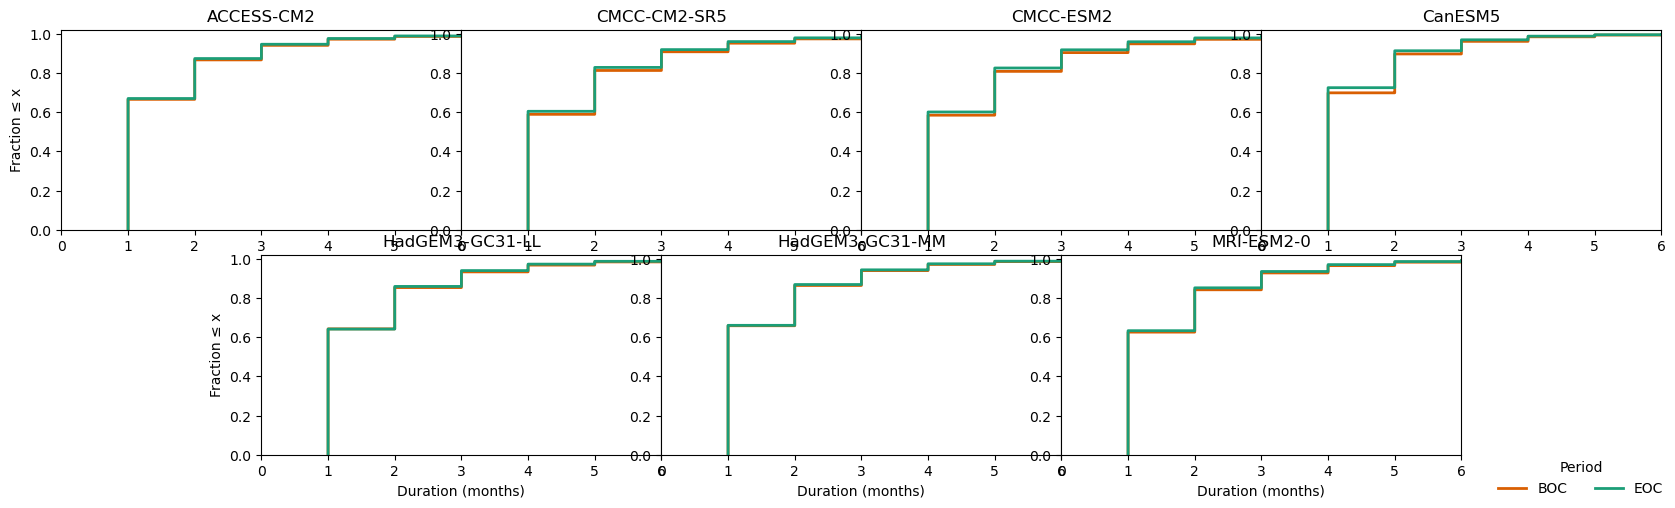

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

models = sorted(all_events['model'].unique())
colors = {'BOC':'#d95f02','EOC':'#1b9e77'}

# global 99th percentile
p99 = all_events['duration'].quantile(0.99)

fig = plt.figure(figsize=(16, 5))

# Parameters for layout
top_h    = 0.45   # fraction of figure height for top row
bottom_h = 0.45   # fraction for bottom
vpad     = 0.05   # vertical padding
hp_total = 1/4    # width fraction per column (4 columns)

# Top row: 4 plots
for i, model in enumerate(models[:4]):
    left = i * hp_total
    ax = fig.add_axes([left, bottom_h + vpad, hp_total, top_h - vpad])
    
    dfm      = all_events[all_events['model']==model]
    boc_vals = np.sort(dfm.loc[dfm.period=='BOC','duration'])
    eoc_vals = np.sort(dfm.loc[dfm.period=='EOC','duration'])
    
    sns.ecdfplot(boc_vals, ax=ax, label='BOC', color=colors['BOC'], linewidth=2)
    sns.ecdfplot(eoc_vals, ax=ax, label='EOC', color=colors['EOC'], linewidth=2)
    
    ax.set_title(model, fontsize=12)
    ax.set_xlim(0, p99)
    ax.set_ylim(0, 1.02)
    
    if i == 0:
        ax.set_ylabel("Fraction ≤ x")
    else:
        ax.set_ylabel("")

    ax.set_xlabel("")  # only bottom row gets xlabel

# Bottom row: 3 plots, centered under columns 1–3
# start left at one hp_total over / 2: i.e. offset = hp_total/2
offset = hp_total / 2
for j, model in enumerate(models[4:]):
    left = offset + j * hp_total
    ax = fig.add_axes([left, vpad, hp_total, bottom_h - vpad])
    
    dfm      = all_events[all_events['model']==model]
    boc_vals = np.sort(dfm.loc[dfm.period=='BOC','duration'])
    eoc_vals = np.sort(dfm.loc[dfm.period=='EOC','duration'])
    
    sns.ecdfplot(boc_vals, ax=ax, label='BOC', color=colors['BOC'], linewidth=2)
    sns.ecdfplot(eoc_vals, ax=ax, label='EOC', color=colors['EOC'], linewidth=2)
    
    ax.set_title(model, fontsize=12)
    ax.set_xlim(0, p99)
    ax.set_ylim(0, 1.02)
    
    if j == 0:
        ax.set_ylabel("Fraction ≤ x")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("Duration (months)")

# Single legend at the top
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title="Period", loc='lower right', ncol=2, frameon=False)

plt.show()


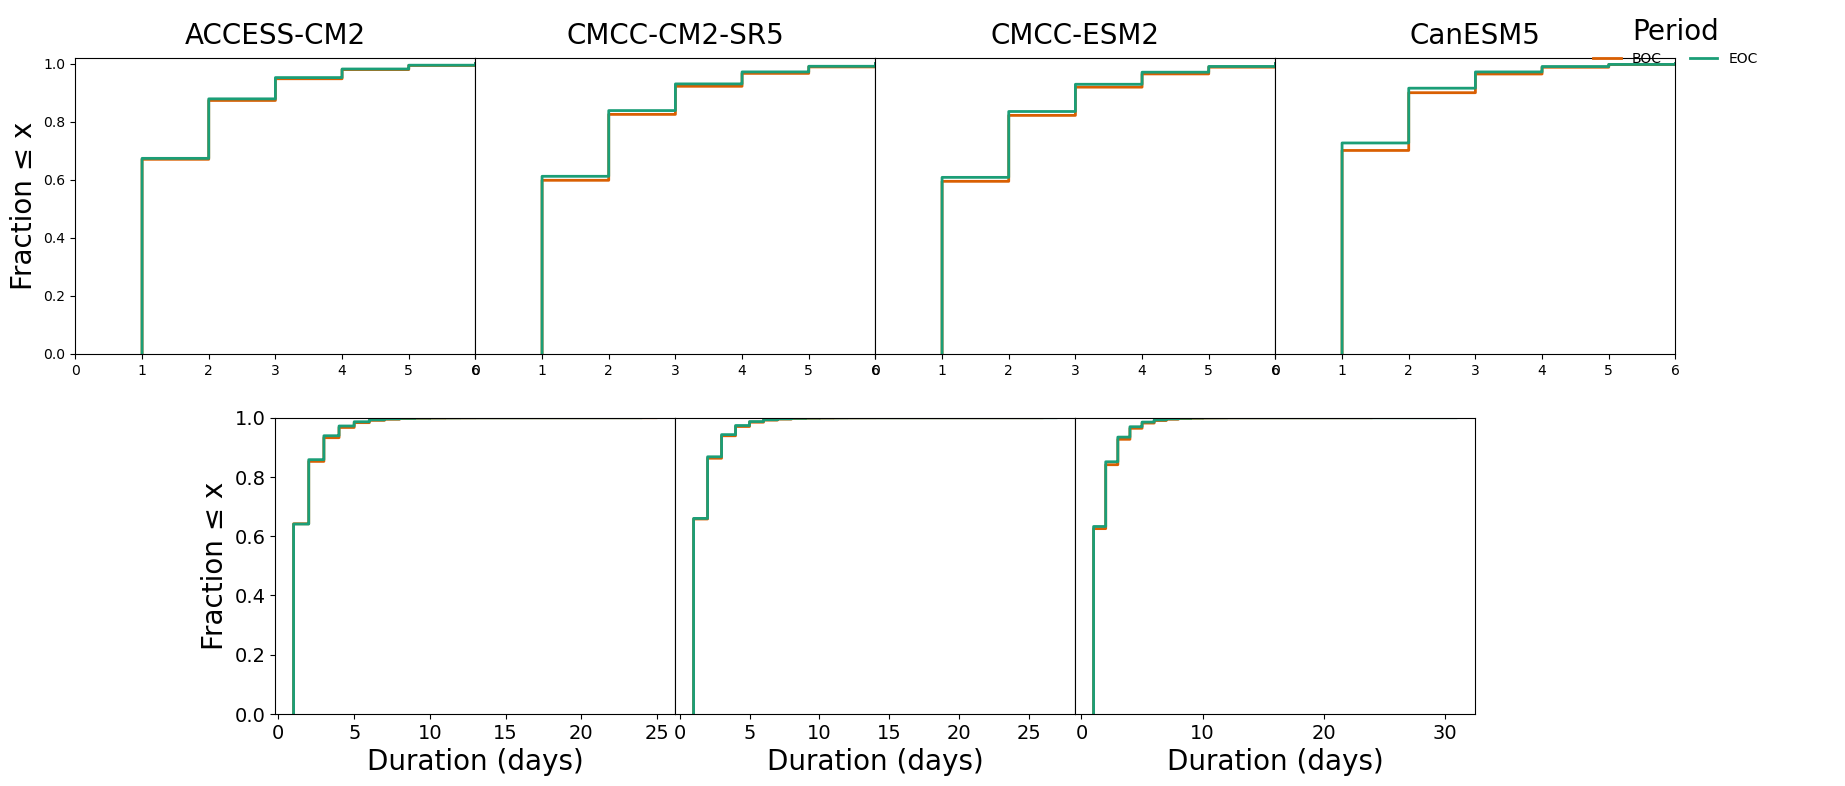

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

models = sorted(all_events['model'].unique())
colors = {'BOC':'#d95f02','EOC':'#1b9e77'}

# global 99th percentile
p99 = all_events['duration'].quantile(0.99)

fig = plt.figure(figsize=(16, 8))

# Parameters
top_h    = 0.45   # fraction of figure height for top row
bottom_h = 0.45   # fraction for bottom
vpad     = 0.08   # vertical padding increased
hp_total = 1/4    # width fraction per column

# Top row: 4 plots
for i, model in enumerate(models[:4]):
    left = i * hp_total
    ax = fig.add_axes([left, bottom_h + vpad, hp_total, top_h - vpad])
    
    dfm      = all_events[all_events['model']==model]
    boc_all  = np.sort(dfm.loc[dfm['period']=='BOC','duration'].values)
    eoc_all  = np.sort(dfm.loc[dfm['period']=='EOC','duration'].values)
    
    # --- clip at p99 ---
    boc_vals = boc_all[boc_all <= p99]
    eoc_vals = eoc_all[eoc_all <= p99]
    
    sns.ecdfplot(boc_vals, ax=ax, label='BOC', color=colors['BOC'], linewidth=2)
    sns.ecdfplot(eoc_vals, ax=ax, label='EOC', color=colors['EOC'], linewidth=2)
    
    ax.set_title(model, fontsize=20, pad=10)
    ax.set_xlim(0, p99)
    ax.set_ylim(0, 1.02)

    # — remove y-ticks on non‐first columns —
    if i != 0:
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)

    # only first column keeps its y‐label
    if i == 0:
        ax.set_ylabel("Fraction ≤ x", fontsize=20)
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")    

# Bottom row: 3 centered plots
offset = hp_total / 2
for j, model in enumerate(models[4:]):
    left = offset + j * hp_total
    ax = fig.add_axes([left, vpad, hp_total, bottom_h - vpad])
    
    dfm      = all_events[all_events['model']==model]
    boc_vals = np.sort(dfm.loc[dfm['period']=='BOC','duration'])
    eoc_vals = np.sort(dfm.loc[dfm['period']=='EOC','duration'])
    
    sns.ecdfplot(boc_vals, ax=ax, label='BOC', color=colors['BOC'], linewidth=2)
    sns.ecdfplot(eoc_vals, ax=ax, label='EOC', color=colors['EOC'], linewidth=2)
    
     # — enlarge tick labels —
    ax.tick_params(axis='x', labelsize=14)  
    ax.tick_params(axis='y', labelsize=14)

    # — remove y-ticks on non‐first columns —
    if j != 0:
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)

    # only first of bottom row keeps its y‐label
    if j == 0:
        ax.set_ylabel("Fraction ≤ x", fontsize=20)
    else:
        ax.set_ylabel("")
    ax.set_xlabel("Duration (days)", fontsize=20)

# A dedicated legend axes in the top-right corner
leg_ax = fig.add_axes([0.9, 0.88, 0.2, 0.08])  # [left, bottom, width, height]
leg_ax.axis('off')
for period, color in colors.items():
    leg_ax.plot([], [], color=color, lw=2, label=period)
leg = leg_ax.legend(loc='center', ncol=2, title="Period", frameon=False)
plt.setp(leg.get_title(), fontsize=20)

#fig.suptitle("ECDF of Drought Durations by Model (up to 99th percentile)", fontsize=16, y=0.96)
plt.show()


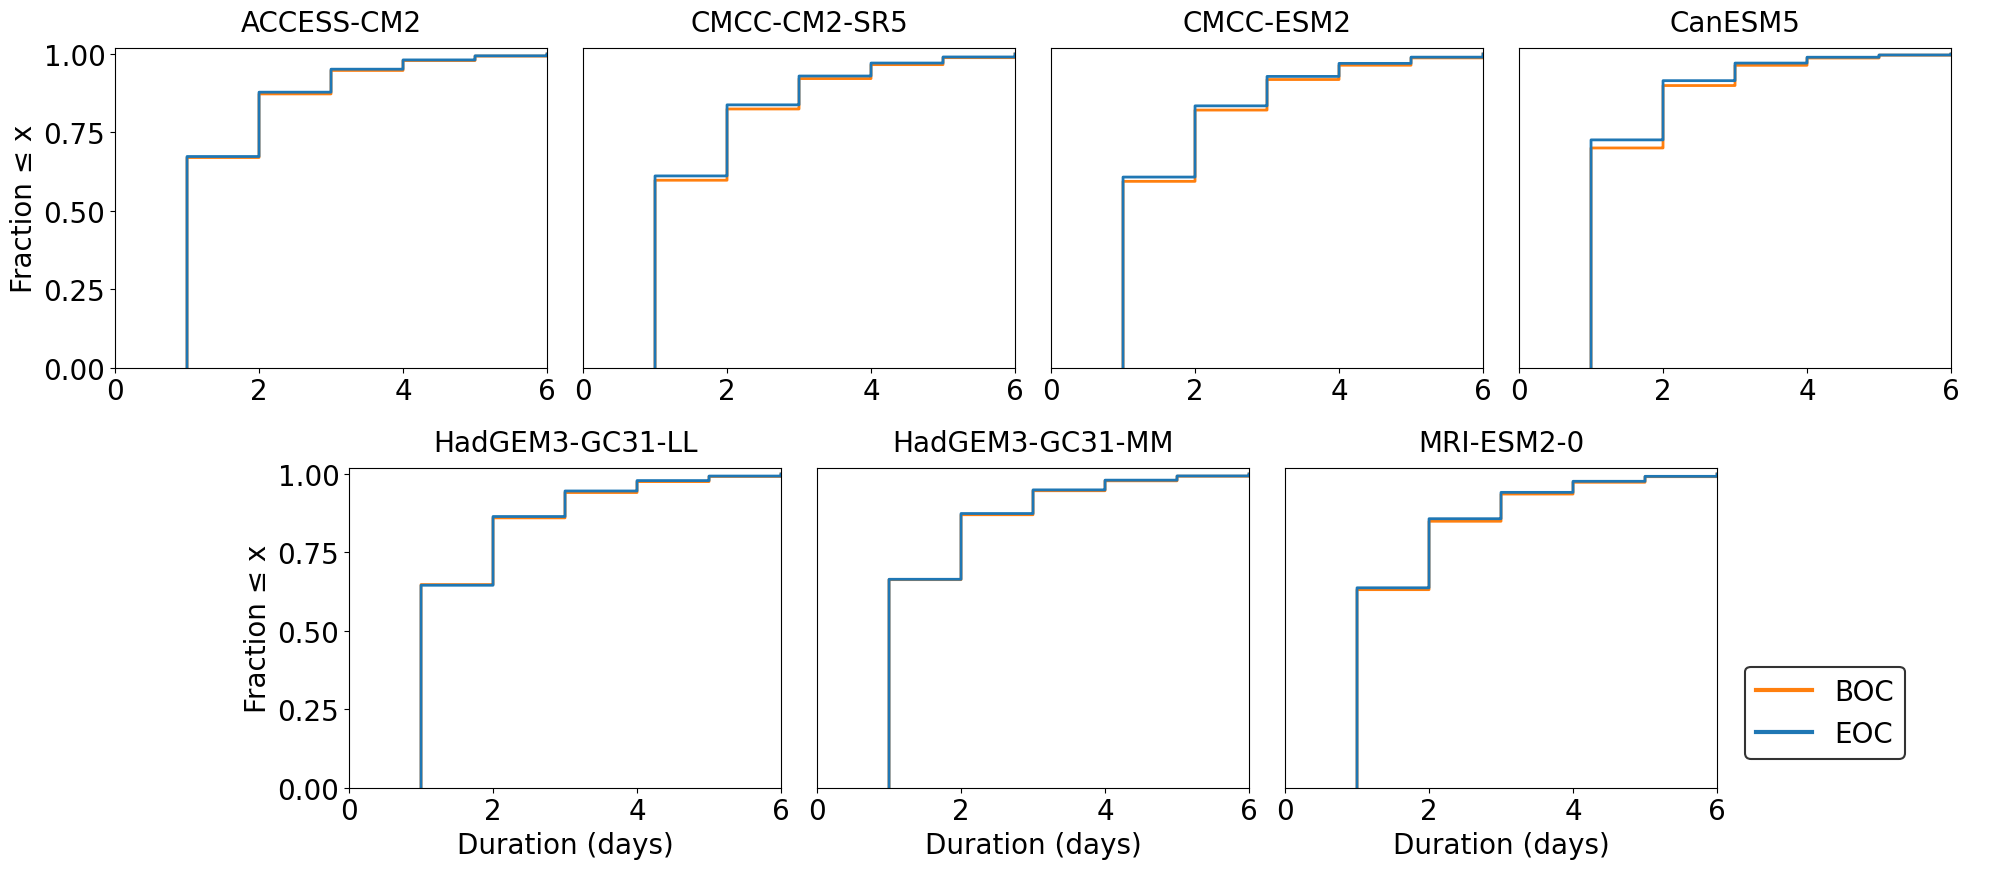

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_boc = "#ff7f0e"  # soft light blue
color_eoc= "#1f77b4"
models = sorted(all_events['model'].unique())
colors = {'BOC':color_boc,'EOC':color_eoc}
p99    = all_events['duration'].quantile(0.99)

fig = plt.figure(figsize=(18,10))

# Layout fractions (slightly smaller panels + bigger pad)
top_h    = 0.42
bottom_h = 0.42
vpad     = 0.10
hp_total = 0.24   # a bit smaller than 0.25 to create gaps

# Top row
for i, model in enumerate(models[:4]):
    left = 0.02 + i * (hp_total + 0.02)  # small horizontal gutter
    ax = fig.add_axes([left, bottom_h+vpad, hp_total, top_h-vpad])
    
    dfm      = all_events[all_events['model']==model]
    boc_all  = np.sort(dfm.loc[dfm['period']=='BOC','duration'])
    eoc_all  = np.sort(dfm.loc[dfm['period']=='EOC','duration'])
    boc_vals = boc_all[boc_all <= p99]
    eoc_vals = eoc_all[eoc_all <= p99]
    
    sns.ecdfplot(boc_vals, ax=ax, label='BOC', color=colors['BOC'], linewidth=2)
    sns.ecdfplot(eoc_vals, ax=ax, label='EOC', color=colors['EOC'], linewidth=2)
    
    ax.set_title(model, fontsize=20, pad=12)
    ax.set_xlim(0, p99)
    ax.set_ylim(0, 1.02)
    
    # enlarge ticks
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    
    # only first column shows y-axis
    if i != 0:
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)
        ax.set_ylabel("")
    else:
        ax.set_ylabel("Fraction ≤ x", fontsize=20)
    ax.set_xlabel("")

# Bottom row
for j, model in enumerate(models[4:]):
    # center under cols 1–3
    left = 0.02 + (j+0.5) * (hp_total + 0.02)
    ax = fig.add_axes([left, vpad, hp_total, bottom_h-vpad])
    
    dfm      = all_events[all_events['model']==model]
    boc_all  = np.sort(dfm.loc[dfm['period']=='BOC','duration'])
    eoc_all  = np.sort(dfm.loc[dfm['period']=='EOC','duration'])
    boc_vals = boc_all[boc_all <= p99]
    eoc_vals = eoc_all[eoc_all <= p99]
    
    sns.ecdfplot(boc_vals, ax=ax, label='BOC', color=colors['BOC'], linewidth=2)
    sns.ecdfplot(eoc_vals, ax=ax, label='EOC', color=colors['EOC'], linewidth=2)
    
    ax.set_title(model, fontsize=20, pad=12)
    ax.set_xlim(0, p99)
    ax.set_ylim(0, 1.02)
    
    # enlarge ticks
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    
    if j != 0:
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)
        ax.set_ylabel("")
    else:
        ax.set_ylabel("Fraction ≤ x", fontsize=20)
    ax.set_xlabel("Duration (days)", fontsize=20)

# Legend in its own axes
leg_ax = fig.add_axes([0.87, 0.15, 0.2, 0.05]) 
leg_ax.axis('off')
for period, color in colors.items():
    leg_ax.plot([], [], color=color, lw=3, label=period)
leg = leg_ax.legend(loc='center', ncol=1, title="", frameon=True, fontsize=20)
leg.set_frame_on(True)
f = leg.get_frame()
f.set_edgecolor('black')
f.set_linewidth(1.5)
f.set_facecolor('white')
plt.setp(leg.get_title(), fontsize=20)

#plt.suptitle("ECDF of Drought Durations by Model (up to 99th percentile)", fontsize=22, y=0.97)
plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/per_model_duration.pdf", bbox_inches='tight', dpi=300)
plt.show()
